# Skin Acne Detection using Dlib and OpenCV

## Introduction

This notebook demonstrates an acne detection algorithm that works on images of human faces. Using **Dlib**'s frontal face detector and **OpenCV**, we can detect facial landmarks and isolate regions of the face for acne detection. The system analyzes contours on the skin and computes an acne severity score by evaluating the relative area affected by acne.

---

## Setup and Dependencies

Ensure the following libraries are installed:
- **dlib**: For detecting faces and facial landmarks.
- **opencv-python**: For image processing.
- **matplotlib**: For visualizing the results.
```python

In [11]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

---

## Face Detection with Dlib

### Detecting Faces and Facial Landmarks

We use Dlib's pre-trained shape predictor to detect the face and key landmarks (eyes, eyebrows, nose, mouth, etc.). These landmarks help us isolate the facial region where acne detection will be applied.


In [12]:
# Utility function to detect face using Dlib's frontal face detector and 81-point face landmark predictor
def detect_face(img):
    """
    Detects face and key facial landmarks using Dlib's pre-trained shape predictor.
    
    Args:
        img: Input image (in BGR format) containing a human face.

    Returns:
        img: Processed image with facial features isolated.
        orig_img: Original input image.
    """
    # Initialize Dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('model/shape_predictor_81_face_landmarks.dat')  
    
    # Convert image to grayscale for processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect the first face in the image
    rect = detector(gray, 1)[0]
    
    # Predict facial landmarks
    landmarks = predictor(gray, rect)
    
    # Generate convex hulls for various facial regions
    face_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(0, 81)]))
    lebrow_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(17, 22)]))
    rebrow_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(22, 27)]))
    leye_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(36, 42)]))
    reye_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(42, 48)]))
    nose_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(27, 36)]))
    lip_hull = cv2.convexHull(np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(48, 68)]))
    
    # Create masks for various facial regions
    orig_img = img.copy()
    lebrow_mask = np.ones((img.shape[0], img.shape[1]))
    rebrow_mask = np.ones((img.shape[0], img.shape[1]))
    lip_mask = np.ones((img.shape[0], img.shape[1]))
    reye_mask = np.ones((img.shape[0], img.shape[1]))
    leye_mask = np.ones((img.shape[0], img.shape[1]))
    nose_mask = np.ones((img.shape[0], img.shape[1]))
    face_mask = np.zeros((img.shape[0], img.shape[1]))
    
    # Apply convex hulls to generate masks
    face_mask = cv2.fillConvexPoly(face_mask, face_hull, 1).astype(np.uint8)
    nose_mask = cv2.fillConvexPoly(nose_mask, nose_hull, 0).astype(np.uint8)
    reye_mask = cv2.fillConvexPoly(reye_mask, reye_hull, 0).astype(np.uint8)
    leye_mask = cv2.fillConvexPoly(leye_mask, leye_hull, 0).astype(np.uint8)
    lip_mask = cv2.fillConvexPoly(lip_mask, lip_hull, 0).astype(np.uint8)
    lebrow_mask = cv2.fillConvexPoly(lebrow_mask, lebrow_hull, 0).astype(np.uint8)
    rebrow_mask = cv2.fillConvexPoly(rebrow_mask, rebrow_hull, 0).astype(np.uint8)
    
    # Apply bitwise AND to isolate each region
    img = cv2.bitwise_and(img, img, mask=face_mask)
    img = cv2.bitwise_and(img, img, mask=nose_mask)
    img = cv2.bitwise_and(img, img, mask=reye_mask)
    img = cv2.bitwise_and(img, img, mask=leye_mask)
    img = cv2.bitwise_and(img, img, mask=lip_mask)
    img = cv2.bitwise_and(img, img, mask=lebrow_mask)
    img = cv2.bitwise_and(img, img, mask=rebrow_mask)
    
    return img, orig_img


---

## Acne Detection and Severity Scoring

### Detecting Acne and Calculating Severity

The acne detection algorithm uses contour detection on the isolated facial skin regions. By applying adaptive thresholding, we can identify regions that may correspond to acne. The severity score is calculated based on the proportion of the facial area affected by acne.


In [19]:
# Algorithm to detect acne severity
def detect_acne(face, orig_img):
    """
    Detects acne regions on the face and calculates a severity score.
    
    Args:
        face: Image of the face with isolated facial regions.
        orig_img: Original image for visualization.
    
    Returns:
        orig_img: Image with acne regions highlighted.
        acne_area: Ratio of the acne area to the total face area (severity score).
    """
    orig_img = orig_img.copy()
    
    # Convert face image to grayscale
    gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    h1, w1 = gray.shape
    
    # Calculate the face area based on non-zero pixels
    face_area = np.count_nonzero(gray) / (h1 * w1)
    
    # Apply adaptive thresholding to detect potential acne regions
    th3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 4)
    th3 = cv2.dilate(th3, np.ones((1, 1)), iterations=2)  # Reduce dilation to avoid over-expanding regions
    
    # Find contours of potential acne spots
    contours, _ = cv2.findContours(th3.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    acne_area = 0  # Initialize acne area
    
    # Filter contours based on size and shape (acne spots should be small and near-circular)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 40 <= area <= 90:  # Acne spots should have a reasonable size
            (x, y, w, h) = cv2.boundingRect(cnt)
            cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Highlight acne regions
            acne_area += w * h
    
    # Calculate acne area relative to the total face area
    acne_area = acne_area / (h1 * w1)
    
    return orig_img, acne_area / face_area


---

## Visualizing the Results

### Displaying the Original Image and Acne Severity Score

In this section, we process the image, detect the acne spots, and display the original image along with the acne severity score and highlighted acne regions.


In [20]:
# Show and process each image
def process_and_show_img(img_path):
    """
    Processes the input image, detects acne, and displays the results.
    
    Args:
        img_path: Path to the input image.
    """
    # Read and process the input image
    img = cv2.imread(img_path)
    face, orig_img = detect_face(img)
    acne_face, acne_area = detect_acne(face, orig_img)
    
    # Convert images from BGR to RGB for display
    acne_face = cv2.cvtColor(acne_face, cv2.COLOR_BGR2RGB)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Plot the original and processed images
    plt.figure(figsize=(16, 10))
    ax1 = plt.subplot(121)
    ax1.set_title('Original Image')
    ax1.imshow(orig_img)
    plt.axis('off')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'Acne Severity Score: {np.uint8(acne_area * 100)}')
    ax2.imshow(acne_face)
    plt.axis


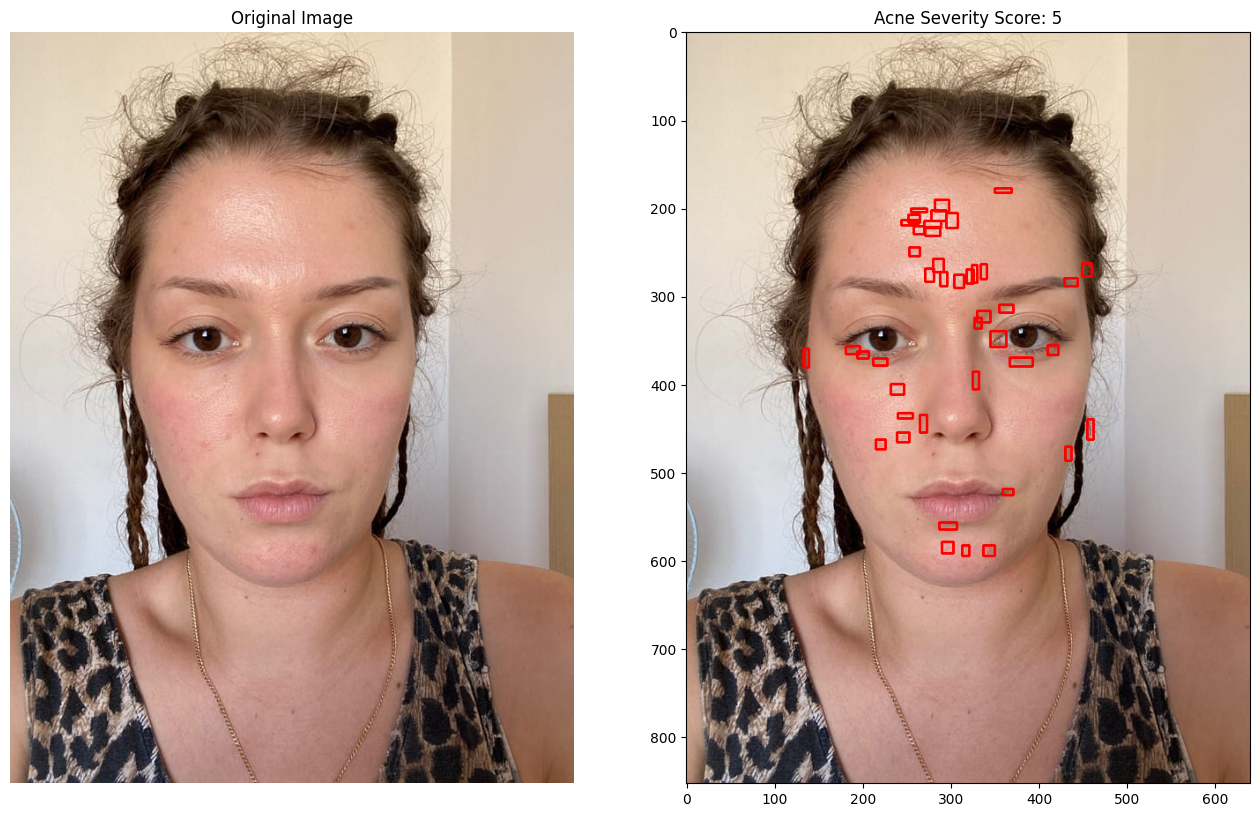

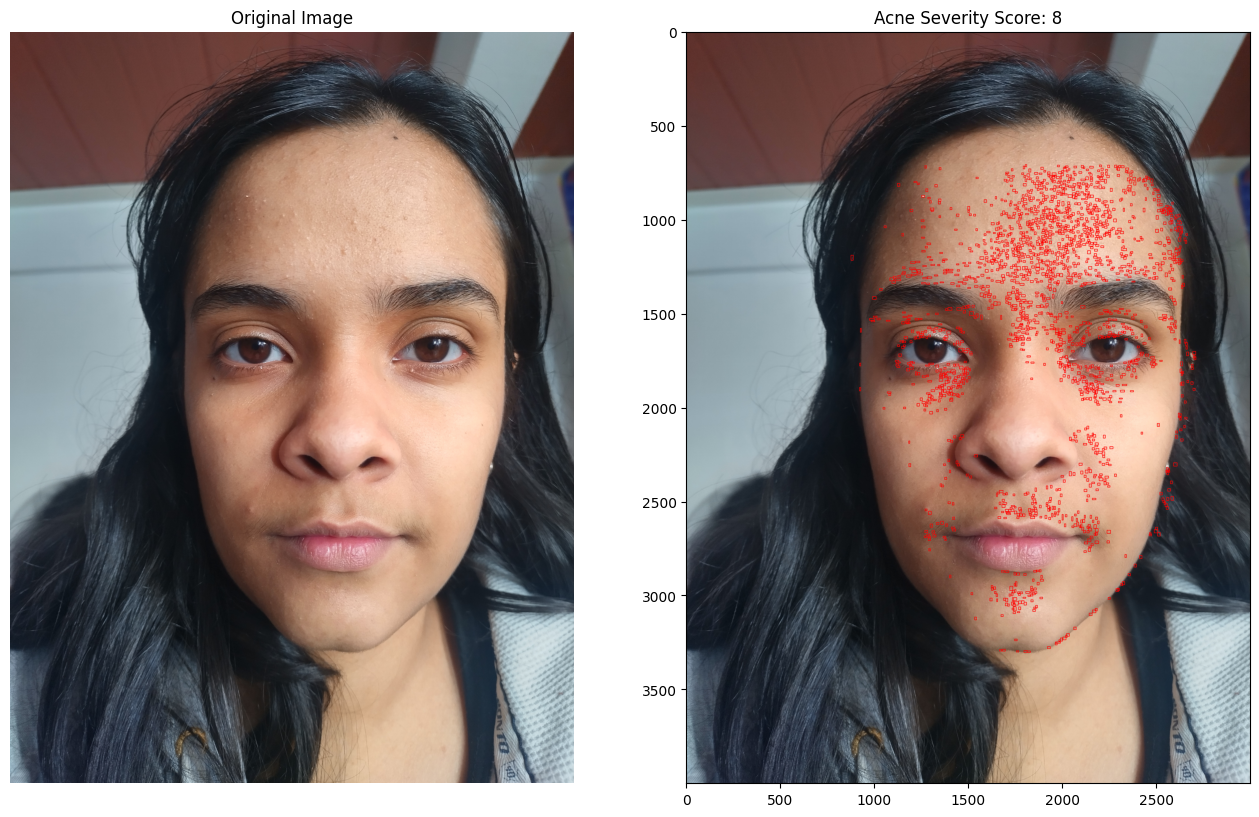

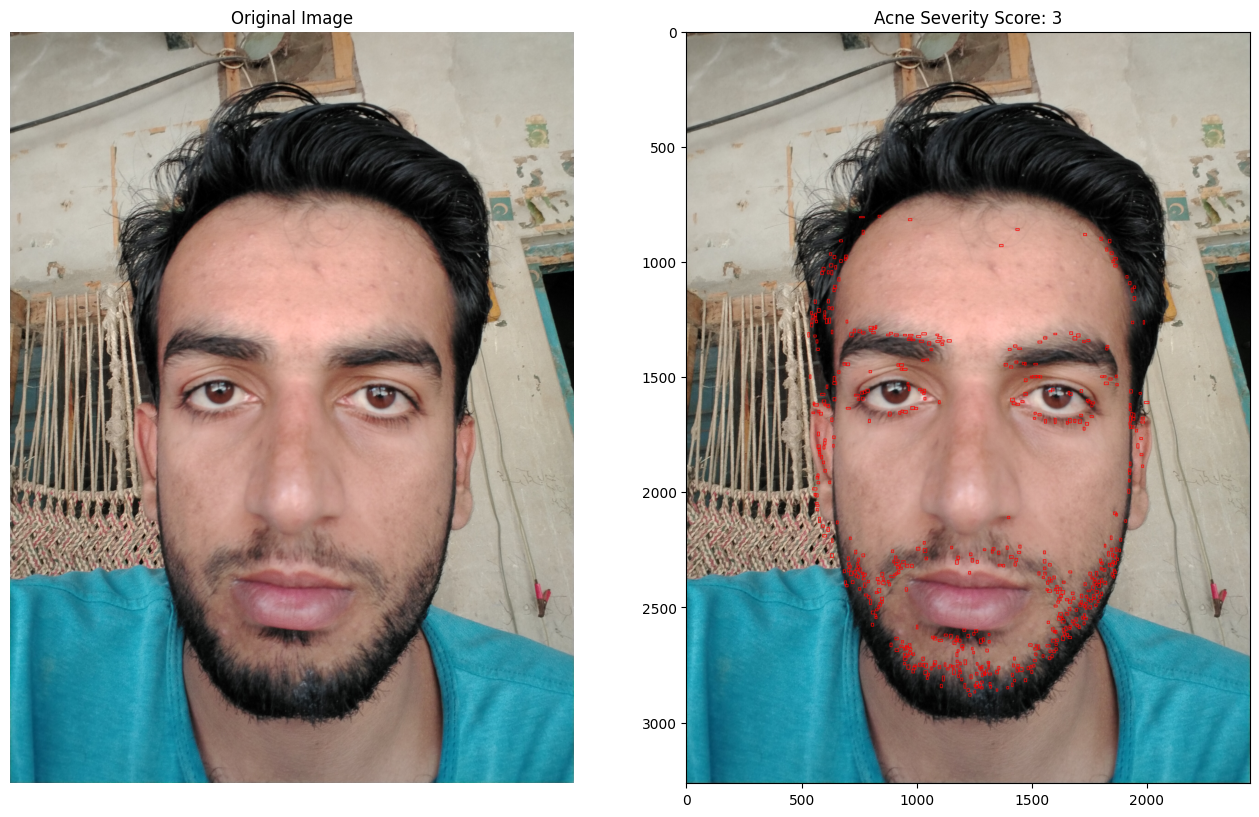

In [21]:
process_and_show_img('datatset/files/acne/3/front.jpg')
process_and_show_img('datatset/files/acne/5/front.jpg')
process_and_show_img('datatset/files/acne/8/front.jpg')



---

## Conclusion

While this model shows promising results in detecting acne, we can observe that at times it misinterprets facial hair and other skin spots as acne, indicating there is still room for error. Therefore, this model may occasionally provide flawed results due to the misrecognition of acne with facial hair or other non-acne spots.

### Next Steps

In the next notebook, we will focus on implementing **YOLO (You Only Look Once)**, a more robust deep learning technique for detecting different types of acne. YOLO will allow us to:
- Detect various types of acne (e.g., cysts, pustules, etc.) with greater precision.
- Accurately determine the severity level of acne by quantifying the number of acne spots, improving the assessment of skin condition.

Moreover, we will also work on **Skin Lesion Detection** to identify potential skin problems. In cases where the detected lesion may indicate a serious condition, such as skin cancer, we will not recommend any skincare product. Instead, we will advise the customer to consult a doctor for a professional medical opinion.

By moving to a deep learning-based approach, we aim to enhance both the accuracy and the diagnostic capability of the model for a more reliable skincare analysis.
